We start by activating the GPU

In [1]:
# We check the tensorflow version (only if we work under colab)
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [42]:
# We import the librairies
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow
import tensorflow as tf
from tensorflow import keras

# matplotlib, numpy, pandas and sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import sklearn
import io

from sklearn import preprocessing

# tf.keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping  
from keras.models import load_model

print(tf.__version__)

2.8.0


In [3]:
# loading dataset
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['heart_train_6.txt']), sep=' ')
# shuffle the dataset to improve the results of our futur model
df = sklearn.utils.shuffle(df)

Saving heart_train_6.txt to heart_train_6.txt


In [43]:
df

,66.0,0.0,1.0,150.0,226.0,0.0.1,0.0.2,114.0,0.0.3,2.6,3.0,0.0.4,3.0.1,1
77,70.0,1.0,4.0,145.0,174.0,0.0,0.0,125.0,1.0,2.6,3.0,0.0,7.0,2
135,42.0,1.0,3.0,120.0,240.0,1.0,0.0,194.0,0.0,0.8,3.0,0.0,7.0,1
59,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,1
201,51.0,1.0,3.0,100.0,222.0,0.0,0.0,143.0,1.0,1.2,2.0,0.0,3.0,1
62,41.0,1.0,4.0,110.0,172.0,0.0,2.0,158.0,0.0,0.0,1.0,0.0,7.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,52.0,1.0,4.0,125.0,212.0,0.0,0.0,168.0,0.0,1.0,1.0,2.0,7.0,2
18,71.0,0.0,3.0,110.0,265.0,1.0,2.0,130.0,0.0,0.0,1.0,1.0,3.0,1
84,53.0,1.0,4.0,123.0,282.0,0.0,0.0,95.0,1.0,2.0,2.0,2.0,7.0,2
55,58.0,1.0,3.0,140.0,211.0,1.0,2.0,165.0,0.0,0.0,1.0,0.0,3.0,1


In [82]:
x = df.iloc[:,range(13)]
y = df.iloc[:,[13]]
x = x.values
y = y.values

# encoding the target
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
print(y.shape)

# separate the data into 4 categories: train (with x and y) and test (with x and y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=1, stratify=y)

(215, 3)


In [79]:
# I tried to scale but it wasn't necessary
#scaler = preprocessing.StandardScaler().fit(x_train)
#x_train = scaler.transform(x_train)

Result >0 : relu, between 0 and 1 : sigmoid, tanh for binary classification 

Softmax is for the output : we have 1 output equal to 1 and all of the others to 0

For relu we use the kernel_initializer he_uniform but for sigmoid or tanh we use glorot

kernel initializer initialize the weights for connexions in our neural network at the beginning

In [104]:
#define network
# in the first place, since it's a binary problem, I tried with the activation tanh and the glorot kernel_initializer 
#kernel_initializer=keras.initializers.glorot_uniform()
# but I had a better result with relu and he_uniform
# I added the layers dropout to prevent the overfitting, for the same reason I added kernel_regularizers
model = keras.Sequential([
    keras.layers.Dense(40, input_dim=13, activation='relu', kernel_initializer='he_uniform',kernel_regularizer= keras.regularizers.l2(0.0005)),
    keras.layers.BatchNormalization(),keras.layers.Dropout(0.2),
    keras.layers.Dense(6, input_dim=11, activation='relu', kernel_initializer='he_uniform',kernel_regularizer= keras.regularizers.l2(0.0005)),
    keras.layers.BatchNormalization(),keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])

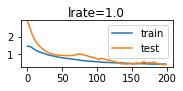

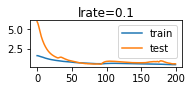

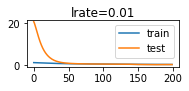

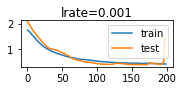

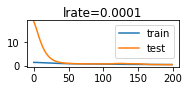

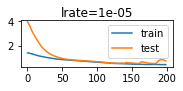

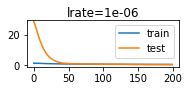

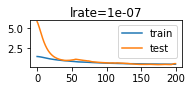

In [123]:
# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(x_train, y_train, x_test, y_test, learning_rates[i])
	# show learning curves
	plt.legend()
	plt.show()
 
 # We can see that the lrate is good for 0.01, 0.0001 and 1e-06
 # therefore I choose lrate = 0.01

In [122]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, lrate):
  # define model
  model = keras.Sequential([
      keras.layers.Dense(40, input_dim=13, activation='relu', kernel_initializer='he_uniform',kernel_regularizer= keras.regularizers.l2(0.0005)),
      keras.layers.BatchNormalization(),keras.layers.Dropout(0.2),
      keras.layers.Dense(6, input_dim=11, activation='relu', kernel_initializer='he_uniform',kernel_regularizer= keras.regularizers.l2(0.0005)),
      keras.layers.BatchNormalization(),keras.layers.Dropout(0.2),
      keras.layers.Dense(3, activation='softmax')
  ])
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
  # fit model
  history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

  plt.plot(smooth_curve(history.history['loss']), label='train')
  plt.plot(smooth_curve(history.history['val_loss']), label='test')
  plt.title('lrate='+str(lrate), pad=-50)

In [27]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [125]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=0,patience=150)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lrate = 0.01
# I tried with this optimizer first but adam was better : 
#keras.optimizers.SGD(learning_rate= lrate)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1800, verbose=0,callbacks=[es, mc])

saved_model = load_model('best_model.h5')


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy improved from 0.50000 to 0.63636, saving model to best_model.h5

Epoch 4: val_accuracy improved from 0.63636 to 0.68182, saving model to best_model.h5

Epoch 5: val_accuracy did not improve from 0.68182

Epoch 6: val_accuracy did not improve from 0.68182

Epoch 7: val_accuracy did not improve from 0.68182

Epoch 8: val_accuracy did not improve from 0.68182

Epoch 9: val_accuracy did not improve from 0.68182

Epoch 10: val_accuracy improved from 0.68182 to 0.77273, saving model to best_model.h5

Epoch 11: val_accuracy did not improve from 0.77273

Epoch 12: val_accuracy did not improve from 0.77273

Epoch 13: val_accuracy did not improve from 0.77273

Epoch 14: val_accuracy did not improve from 0.77273

Epoch 15: val_accuracy improved from 0.77273 to 0.81818, saving model to best_model.h5

Epoch 16: val_accuracy did not improve fr

In [134]:
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 40)                560       
                                                                 
 batch_normalization_67 (Bat  (None, 40)               160       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_122 (Dense)           (None, 6)                 246       
                                                                 
 batch_normalization_68 (Bat  (None, 6)                24        
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 6)               

In [135]:
#test accuracy and loss
test_loss, test_acc = saved_model.evaluate(x_test, y_test, verbose=2)
print(test_loss, test_acc)

1/1 - 0s - loss: 0.4619 - accuracy: 0.8636 - 26ms/epoch - 26ms/step
0.46186578273773193 0.8636363744735718


In [136]:
#test accuracy and loss
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

Train: 0.8756, Test: 0.8636


In [137]:
predictions = saved_model.predict(x_test)
predictions[1]

print(np.argmax(predictions[1]))
print(y_test[1])

1
[0. 1. 0.]


In [138]:
print(history.history.keys())
print(saved_model.summary())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 40)                560       
                                                                 
 batch_normalization_67 (Bat  (None, 40)               160       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_122 (Dense)           (None, 6)                 246       
                                                                 
 batch_normalization_68 (Bat  (None, 6)                24        
 chNormalization)                                                
                                                           

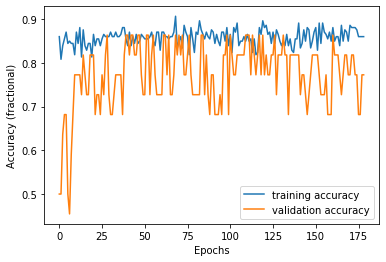

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (fractional)')
plt.legend(['training accuracy', 'validation accuracy'], loc='best')

# We can see that the model is learning without overfitting

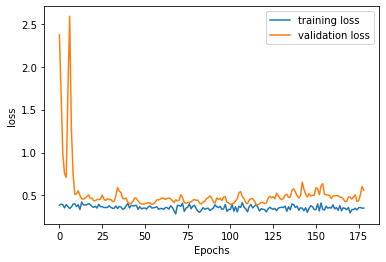

In [131]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'], loc='best')

# The curves are getting closer so there is no overfitting

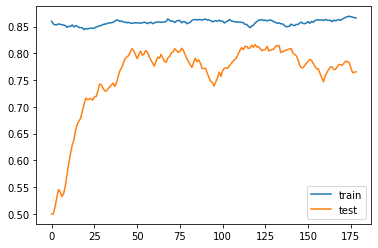

In [132]:
plt.plot(smooth_curve(history.history['accuracy']), label='train')
plt.plot(smooth_curve(history.history['val_accuracy']), label='test')
plt.legend()

# We can see that the accuracy of the test curve increase with the epochs, it's getting closer to the train curve

In [98]:
uploaded2 = files.upload()
df_test = pd.read_csv('heart_test.txt', sep=' ')

In [99]:
df_test = sklearn.utils.shuffle(df_test)

In [100]:
testx = df_test.iloc[:,range(13)]
testy = df_test.iloc[:,[13]]
testx = testx.values
testy = testy.values
testy = to_categorical(testy)
print(testy.shape)

(53, 3)


In [133]:
_, test_acc = saved_model.evaluate(testx, testy, verbose=0)
print('Test: %.4f' % (test_acc))
# 88.68% of the heart_test was predicted correctly (with 0,0,1 if the value is 2 (presence of heart disease) or 0,1,0 if the value is 1 (no heart disease))

Test: 0.8868


Final accuracy for heart_test.txt : 88.68%